# Experimenting with re-writing the model with PyMC3.

In [7]:
%matplotlib inline

In [376]:
import numpy as np
import pandas as pd
import emcee
import corner

import astropy.stats as aps
import astropy.coordinates as coord
import astropy.units as u
from astropy.coordinates.builtin_frames.galactocentric \
    import get_matrix_vectors
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

import aviary as av
import theano.tensor as tt

In [9]:
# Solar coords
sun_xyz = [-8.122, 0, 0] * u.kpc
sun_vxyz = [12.9, 245.6, 7.78] * u.km/u.s

galcen_frame = coord.Galactocentric(galcen_distance=np.abs(sun_xyz[0]),
                                    galcen_v_sun=sun_vxyz,
                                    z_sun=0*u.pc)

# Pre-compute the rotation matrix to go from Galactocentric to ICRS
# (ra/dec) coordinates
R_gal, _ = get_matrix_vectors(galcen_frame, inverse=True)

print(R_gal)

[[-0.05487396  0.49411076 -0.86766549]
 [-0.87343718 -0.44482862 -0.19807824]
 [-0.48383503  0.74698196  0.45598422]]


In [10]:
# Calculate prior parameters from vx, vy, vz distributions.
vels = pd.read_csv("../../data/gaia_lamost_mc_velocities.csv")
m = vels.radial_velocity.values != 0
vels = vels.iloc[m]

# Calculate covariance between velocities
VX = np.stack((vels.basic_vx.values, vels.basic_vy.values,
               vels.basic_vz.values, np.log(1./vels.parallax.values)), axis=0)
mean = np.mean(VX, axis=1)
cov = np.cov(VX)

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (27,30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Matrix for calculating Galactocentric positions from equatorial coordinates.

In [ ]:
def r_icrs(ra_deg, dec_deg, d):
    ra, dec = deg_to_rad(np.array([ra_deg, dec_deg]))
    return np.array([[d * np.cos(ra) * np.cos(dec)],
                     [d * np.sin(ra) * np.cos(dec)],
                     [d * np.sin(dec)]])

def eqtogal(ra, dec, d):
    
    r = r_icrs(ra, dec, d)
    R1 = np.array([[np.cos(dec_gc), 0, np.sin(dec_gc)],
                   [0, 1, 0],
                   [-np.sin(dec_gc), 0, np.cos(dec_gc)]])
    R2 = np.array([[np.cos(ra_gc), np.sin(ra_gc), 0],
                   [-np.sin(ra_gc), np.cos(ra_gc), 0],
                   [0, 0, 1]])
    R3 = np.array([[1, 0, 0],
                   [0, np.cos(eta), np.sin(eta)],
                   [0, -np.sin(eta), np.cos(eta)]])
    R1_R2 = np.dot(R1, R2)
    R = np.dot(R3, R1_R2)
    
    xhat = np.array([[1, 0, 0]]).T
    R_r = np.dot(R, r)
    rdash = R_r - d_gc * xhat
    
    theta = np.arcsin(zsun/d_gc)
    H = np.array([[np.cos(theta), 0, np.sin(theta)],
                  [0, 1, 0],
                  [-np.sin(theta), 0, np.cos(theta)]])
    
    rgc = np.dot(H, rdash)
    return rgc

Code for converting km/s to mas/yr.

In [378]:
def cartesian_to_angular_no_units(km_s, kpc):
    to_km_yr = 365.2425 * 24*3600
    to_m_yr = 1000
    to_kpc_yr = 1./3.0856775814671917e+19
    to_rad_yr = 1./kpc
    to_deg_yr = 360/(2*np.pi)
    to_mas_yr = 3600*1000
    return np.arcsin((km_s * to_km_yr) * to_m_yr * to_kpc_yr * to_rad_yr) * to_deg_yr * to_mas_yr

In [372]:
def get_tangent_basis(ra, dec):
    """
    row vectors are the tangent-space basis at (alpha, delta, r)
    ra, dec in radians
    """

    # Precompute this matrix and save for each star.
    M = np.array([
        [-np.sin(ra), np.cos(ra), 0.],
        [-np.sin(dec)*np.cos(ra), -np.sin(dec)*np.sin(ra), np.cos(dec)],
        [np.cos(dec)*np.cos(ra), np.cos(dec)*np.sin(ra), np.sin(dec)]
    ])
    return M


def get_icrs_from_galactocentric(xyz, vxyz, ra, dec, distance):

    # Parameters
    dx = xyz - sun_xyz
    dv = vxyz - sun_vxyz

    # M is precomputed for each star, R_gal is same matrix, so just do this
    # dot product.
    proj_dv = M @ R_gal @ dv
    
    print(proj_dv)
    
    # Calculate the unit conversion using 1kms/1km and transform.
    pm = (proj_dv[:2] / (distance*u.kpc)).to(u.mas/u.yr, u.dimensionless_angles())

    print(cartesian_vel_to_angular_vel(proj_dv[:2], distance))
    print(cartesian_to_angular_no_units(proj_dv[:2].value, distance))
    print(pm)
    rv = proj_dv[2]

    return pm, rv

In [373]:
def lnlike_one_star(params, pm, pm_err, pos, pos_err):

    # Unpack parameters and make distance linear.
    vx, vy, vz, lnD = params
    D = np.exp(lnD)

    # Calculate XYZ position from ra, dec and parallax
    c = coord.SkyCoord(ra = pos[0]*u.deg,
                       dec = pos[1]*u.deg,
                       distance = D*u.kpc)
    galcen = c.transform_to(galcen_frame)

    # Calculate pm and rv from XYZ and V_XYZ
    V_xyz_units = [vx, vy, vz]*u.km*u.s**-1
    pm_from_v, rv_from_v = get_icrs_from_galactocentric(galcen.data.xyz, V_xyz_units, pos[0], pos[1], D)
    
    # Compare this proper motion with observed proper motion.
    return -.5*(pm_from_v[0].value - pm[0])**2/pm_err[0]**2 \
           -.5*(pm_from_v[1].value - pm[1])**2/pm_err[1]**2 \
           -.5*(1./D - pos[2])**2/pos_err[2]**2


def multivariate_lngaussian(pos, mu, Sigma):
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)
    return -fac / 2 - np.log(N)


def lnprior(params):
    vx, vy, vz, lnD = params
    pos = np.stack((vx, vy, vz, lnD))
    return float(multivariate_lngaussian(pos, mean, cov))


def lnprob(params, pm, pm_err, pos, pos_err):
    return lnlike_one_star(params, pm, pm_err, pos, pos_err) + lnprior(params)

In [374]:
# Format parameter and data arrays.
df = vels.iloc[0]

pos = [df["ra"], df["dec"], df["parallax"]]
pos_err = [df["ra_error"], df["dec_error"], df["parallax_error"]]
pm = [df["pmra"], df["pmdec"]]
pm_err = [df["pmra_error"], df["pmdec_error"]]
inits = [df["basic_vx"], df["basic_vy"], df["basic_vz"],
         np.log(1./df["parallax"])]

M = get_tangent_basis(pos[0], pos[1])
print(M, np.shape(M))

[[-0.90626493 -0.42271015  0.        ]
 [-0.33834048  0.72538148  0.59945594]
 [-0.25339611  0.5432659  -0.80040775]] (3, 3)


Test lhf.

In [375]:
lnlike_one_star(inits, pm, pm_err, pos, pos_err)

[-7.89978781 18.4815184  23.5488333 ] km / s
[-14.83074391  34.69645933] mas / yr
[-14.83074391  34.69645933]
[-14.83104845  34.69717179] mas / yr


-161300.67926439925

In [168]:
# Run MCMC.
ndim, nwalkers = 4, 16
p0 = np.random.randn(nwalkers, ndim)*1e-2 + inits
sampler = emcee.EnsembleSampler(nwalkers, ndim, av.lnprob,
                                args=(pm, pm_err, pos, pos_err))

nsteps = 100
sampler.run_mcmc(p0, nsteps, progress=True);

# Extract inferred parameters and uncertainties.
flat_samples = sampler.get_chain(discard=int(nsteps/2), flat=True)
params_inferred = np.median(flat_samples, axis=0)

 17%|█▋        | 17/100 [00:01<00:07, 10.51it/s]Traceback (most recent call last):
  File "/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/rangus/projects/aviary/aviary/inference.py", line 182, in lnprob
    return lnlike_one_star(params, pm, pm_err, pos, pos_err) + lnprior(params)
  File "/Users/rangus/projects/aviary/aviary/inference.py", line 104, in lnlike_one_star
    pm_from_v, rv_from_v = proper_motion_model(params, pos)
  File "/Users/rangus/projects/aviary/aviary/inference.py", line 69, in proper_motion_model
    galcen = c.transform_to(galcen_frame)
  File "/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/astropy/coordinates/sky_coordinate.py", line 442, in transform_to
    new_coord = trans(self.frame, generic_frame)
  File "/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/astropy/coordinates/transformations.py", line 1382,

emcee: Exception while calling your likelihood function:
  params: [ -8.89724563 224.13813637   2.78238484  -2.18261978]
  args: ([11.035856985126493, 21.341856214187025], [0.04921520115408177, 0.06202796979847151], [291.03375415995947, 36.771136728882695, 8.899751332953752], [0.020699824905698168, 0.027315001853058653, 0.025810174130249525])
  kwargs: {}
  exception:


KeyboardInterrupt: 

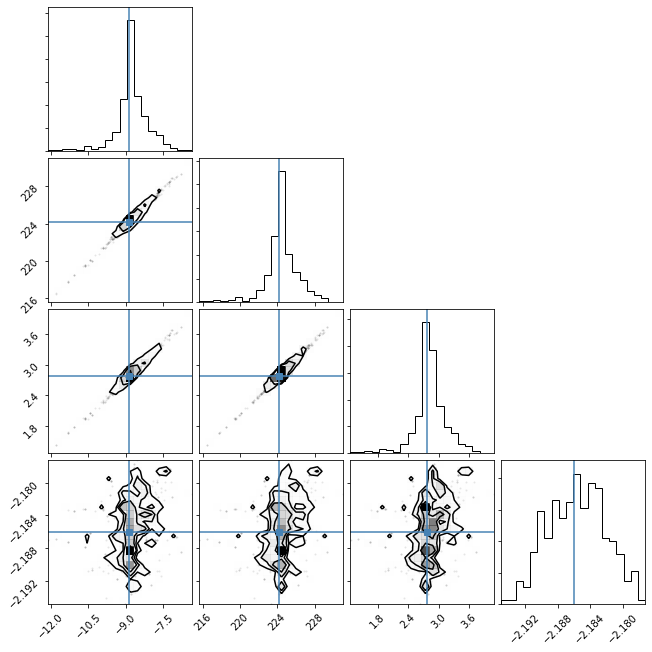

In [69]:
fig = corner.corner(flat_samples, truths=inits)
fig.savefig("corner")

Now try to rewrite this in PyMC3...

In [ ]:
# Things I need:
# A matrix rotation to go from ra, dec, distance to x, y, z.


with pm.Model() as model:
        
    # Set up the parameters
    params = pm.MvNormal("params", mu=mean, cov=cov, shape=(4))

    
    # The model
    
    # Parameters
    dx = xyz - sun_xyz
    dv = vxyz - sun_vxyz

    # M is precomputed for each star, R_gal is same matrix, so just do this
    # dot product.
    proj_dv = M @ R_gal @ dv
    
    # Calculate the unit conversion using 1kms/1km and transform.
    pm = (proj_dv[:2] / (distance*u.kpc)).to(u.mas/u.yr, u.dimensionless_angles())
    rv = proj_dv[2]
    
    

    
    
    
    
    
    
    # Likelihood
    pm.Normal("parallax_obs", mu=mu, sigma=np.array(df.parallax_error),
              observed=np.array(df.parallax_mas))
    
    simple_trace = pm.sample(tune=5000, draws=5000)

In [16]:
# Calculate XYZ position from ra, dec and parallax
c = coord.SkyCoord(ra = df.ra*u.deg,
                   dec = df.dec*u.deg,
                   distance = (1./df.parallax)*u.kpc)
galcen = c.transform_to(galcen_frame)
galcen.data.xyz

<Quantity [-8.08294007,  0.10357572,  0.01928123] kpc>

In [29]:
# Calculate XYZ position from ra, dec and parallax
ds = np.linspace(0, 100, 100)

x, y, z = [], [], []
for d in ds:
    c = coord.SkyCoord(ra = 0*u.deg,
                       dec = 90*u.deg,
                       distance = d*u.kpc)
    galcen = c.transform_to(galcen_frame)
    x.append(galcen.data.xyz.value[0])
    y.append(galcen.data.xyz.value[1])
    z.append(galcen.data.xyz.value[2])

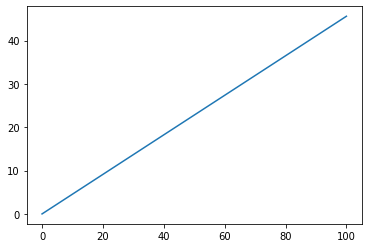

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(ds, z)

TEST. Convert mas/yr to km/s and back. 

In [343]:
pm = 20 * u.mas/u.yr
distance = 5
pm

<Quantity 20. mas / yr>

In [344]:
# Convert to degrees/yr
pm /= ((3600*1000)*u.mas/u.deg)
pm

<Quantity 5.55555556e-06 deg / yr>

In [345]:
# Convert to radians/yr
pm *= 2*np.pi/360 * u.rad/u.deg
pm

<Quantity 9.69627362e-08 rad / yr>

In [346]:
# Convert to distance.
pm *= distance*u.kpc /u.rad
pm

<Quantity 4.84813681e-07 kpc / yr>

In [347]:
import astropy.constants as const

# Convert to m/yr
pm *= const.kpc/u.kpc
pm

<Quantity 1.49597871e+13 m / yr>

In [348]:
# convert to km/yr
pm *= 1e-3*u.km/u.m
pm

<Quantity 1.49597871e+10 km / yr>

In [349]:
# convert to km/s
yr = 24*60*60*365.25
pm /= yr*u.s/u.yr
pm

<Quantity 474.04704635 km / s>

In [350]:
print(pm)
print((pm / (distance*u.kpc)))

474.04704634962087 km / s
94.80940926992417 km / (kpc s)


In [351]:
print((pm / (distance*u.kpc)).to(u.mas/u.yr, u.dimensionless_angles()))

20.000000000000004 mas / yr


Now do that in reverse.

In [377]:
def cartesian_vel_to_angular_vel(km_s, kpc):
    to_km_yr = (365.2425 * 24*3600)*u.s/u.yr
    to_m_yr = 1000*u.m/u.km
    to_kpc_yr = 1./(const.kpc/u.kpc)
    to_rad_yr = u.rad/u.kpc/kpc
    to_deg_yr = 360*u.deg/(2*np.pi*u.rad)
    to_mas_yr = 3600*1000*u.mas/u.deg
    return np.arcsin(((km_s * to_km_yr) * to_m_yr * to_kpc_yr * to_rad_yr).value) *u.rad/u.yr * to_deg_yr * to_mas_yr

def cartesian_to_angular_no_units(km_s, kpc):
    to_km_yr = 365.2425 * 24*3600
    to_m_yr = 1000
    to_kpc_yr = 1./3.0856775814671917e+19
    to_rad_yr = 1./kpc
    to_deg_yr = 360/(2*np.pi)
    to_mas_yr = 3600*1000
    return np.arcsin((km_s * to_km_yr) * to_m_yr * to_kpc_yr * to_rad_yr) * to_deg_yr * to_mas_yr

In [361]:
const.kpc.value

3.0856775814671917e+19

In [362]:
# print((pm * (365.2425 * 24*3600)*u.s/u.yr))  # convert to km/yr
# print((pm * (365.2425 * 24*3600)*u.s/u.yr) * 1000*u.m/u.km)  # convert to m/yr
# print((pm * (365.2425 * 24*3600)*u.s/u.yr) * 1000*u.m/u.km / (const.kpc/u.kpc)) # convert to kpc/yr
# print((pm * (365.2425 * 24*3600)*u.s/u.yr) * 1000*u.m/u.km / (const.kpc/u.kpc) * u.rad/u.kpc/5) # convert to angle
# print((pm * (365.2425 * 24*3600)*u.s/u.yr) * 1000*u.m/u.km / (const.kpc/u.kpc) * u.rad/u.kpc/5 * (360*u.deg/(2*np.pi*u.rad))) # convert to degrees
# print((pm * (365.2425 * 24*3600)*u.s/u.yr) * 1000*u.m/u.km / (const.kpc/u.kpc) * u.rad/u.kpc/5 * (360*u.deg/(2*np.pi*u.rad)) * (3600*1000*u.mas/u.deg)) # convert to mas

In [363]:
print(cartesian_vel_to_angular_vel(pm, distance))
print(cartesian_to_angular_no_units(pm.value, distance))

19.99958932238196 mas / yr
19.99958932238196


In [339]:
pm

<Quantity 474.04704635 km / s>

In [340]:
# Calculate XYZ position from ra, dec and parallax
c = coord.SkyCoord(ra = pos[0]*u.deg,
                   dec = pos[1]*u.deg,
                   distance = 2*u.kpc)
galcen = c.transform_to(galcen_frame)
galcen.data.xyz

<Quantity [-7.42675264,  1.84359631,  0.34319637] kpc>

In [ ]:
def equatorial_to_Galactic(ra, dec, distance):
    pos = 